In [27]:
import os
from typing import List
import random
import numpy as np
import pandas as pd
import seaborn as sns
from hashlib import md5
import matplotlib.pyplot  as plt


GRID_W=5
GRID_H=3
NUM_GRIDS=200

In [28]:
def write_grids(subsets:List[List],path:str):

    #Ensure directory exists
    if not os.path.isdir(path):
        os.mkdir(path)

    grids = [None]*len(subsets)

    #Format every subset in a grid format and save as CSV
    for i,subset in enumerate(subsets):
        csv_file = "".join([element + (';' if (j+1)%GRID_W else '\n')
                            for j,element in enumerate(subset)])[:-1]
        #                               Last character is \n   ^^^^^
        
        with open(os.path.join(path,f"{i}.csv"),"w") as f:
            f.write(csv_file)
        
        grid = csv_file.replace('\n',';').split(';')
        grids[i] = [grid[i:i + GRID_W] for i in range(0, len(grid), GRID_W)]

    return grids

def load_grids(path:str,n_grids:int) -> List[List]:

    grids = [None]*n_grids
    
    for i in range(n_grids):
        with open(os.path.join(path,f"{i}.csv"),"r") as f:
            csv_file = f.read()

        grid = csv_file.replace('\n',';').split(';')
        grids[i] = [grid[i:i + GRID_W] for i in range(0, len(grid), GRID_W)]

    return grids

#Returns the index of the song which the sequence will win on.
def win_on(sequence:list, song2idx):
    return max([song2idx[song] for song in sequence])    

In [29]:
round_n = 1
overwrite = False

def prepare_df(round_n:int,n_grids:int,
               overwrite:bool=False,
               n_songs=100):

    #Retrieve songs
    with open(os.path.join('..','songs',f'songs_{round_n}.txt'),'r',encoding='utf-8') as f:
        songs = [song[:-1] for song in f.readlines()][:n_songs]

    #Maps a song to its position within the playlist
    song2idx = {song:i for i,song in enumerate(songs)}

    #Path of grids in local disk
    grid_path = os.path.join("..","grids",f"grids_{round_n}")

    #Writing/Loading grids
    if overwrite:    
        
        #Create the grids by randomly sampling from the playlist
        grids = [random.sample(songs,GRID_W*GRID_H) for _ in range(n_grids)]

        print(f"[WARNING]: Overwriting grids at {os.path.join(os.getcwd(),grid_path)}",end='\r')
        for f in os.listdir(grid_path): os.remove(os.path.join(grid_path,f))
        grids = write_grids(grids,grid_path)
        
    else:
        grids = load_grids(grid_path,n_grids)
    

    #Contains the winning song index for GRID_H verses for every grid.
    data = [[win_on(vers,song2idx) for vers in grid] for grid in grids]

    #Adding the winning index for any vers
    data = [v+[min(v)] for v in data]

    #Adding the winning index for the whole grid
    #NOTE: When all GRID_H verses are won, the grid is won
    data = [v+[max(v)] for v in data]


    df = pd.DataFrame(
        data=data,
        columns=[f"Vers {i+1}" for i in range(GRID_H)]+["Vers","Kaxxa"]
    )

    return df


In [30]:
for i in [1,2]:
    if not os.path.isdir(p:=os.path.join("..","grids",f"grids_{i}")):
        os.makedirs(p)

round_n = 2
df = prepare_df(round_n,n_grids=290, overwrite=True)
df.to_csv(os.path.join("..","grids",f"grids_{round_n}","data.csv"), index=False)

In [31]:
df

,Vers 1,Vers 2,Vers 3,Vers,Kaxxa
0,64,67,51,51,67
1,59,54,63,54,63
2,56,54,46,46,56
3,62,67,59,59,67
4,61,66,62,61,66
...,...,...,...,...,...
285,64,66,23,23,66
286,65,62,67,62,67
287,57,67,65,57,67
288,67,61,68,61,68


### Generate win-on round graph

In [56]:
from tqdm import tqdm
data = []

GRAN = 5

for i in tqdm(range(GRID_H*GRID_W, 100)):

    df = prepare_df(
        round_n=2,
        n_grids=100,
        n_songs=i,
        overwrite=True
    )
    for _ in range(GRAN-1):
        df += prepare_df(
            round_n=2,
            n_grids=100,
            n_songs=i,
            overwrite=True
        )
    df /= GRAN

    data.append(
        [i,df['Vers' ].min().item(),df['Kaxxa'].min().item()]
    )

  0%|          | 0/85 [00:00<?, ?it/s]

  1%|          | 1/85 [00:00<00:23,  3.51it/s]

  2%|▏         | 2/85 [00:00<00:24,  3.45it/s]

  4%|▎         | 3/85 [00:00<00:24,  3.35it/s]

  5%|▍         | 4/85 [00:01<00:24,  3.31it/s]

  6%|▌         | 5/85 [00:01<00:23,  3.39it/s]

  7%|▋         | 6/85 [00:01<00:22,  3.46it/s]

  8%|▊         | 7/85 [00:02<00:22,  3.54it/s]

  9%|▉         | 8/85 [00:02<00:21,  3.54it/s]

 11%|█         | 9/85 [00:02<00:21,  3.48it/s]

 12%|█▏        | 10/85 [00:02<00:22,  3.38it/s]

 13%|█▎        | 11/85 [00:03<00:21,  3.43it/s]

 14%|█▍        | 12/85 [00:03<00:21,  3.40it/s]

 15%|█▌        | 13/85 [00:03<00:21,  3.38it/s]

 16%|█▋        | 14/85 [00:04<00:22,  3.13it/s]

 18%|█▊        | 15/85 [00:04<00:22,  3.17it/s]

 19%|█▉        | 16/85 [00:04<00:23,  2.99it/s]

 20%|██        | 17/85 [00:05<00:21,  3.10it/s]

 21%|██        | 18/85 [00:05<00:20,  3.20it/s]

 22%|██▏       | 19/85 [00:05<00:19,  3.36it/s]

 24%|██▎       | 20/85 [00:05<00:18,  3.52it/s]

 25%|██▍       | 21/85 [00:06<00:17,  3.59it/s]

 26%|██▌       | 22/85 [00:06<00:17,  3.60it/s]

 27%|██▋       | 23/85 [00:06<00:17,  3.61it/s]

 28%|██▊       | 24/85 [00:07<00:16,  3.64it/s]

 29%|██▉       | 25/85 [00:07<00:16,  3.61it/s]

 31%|███       | 26/85 [00:07<00:16,  3.66it/s]

 32%|███▏      | 27/85 [00:07<00:16,  3.58it/s]

 33%|███▎      | 28/85 [00:08<00:16,  3.53it/s]

 34%|███▍      | 29/85 [00:08<00:15,  3.50it/s]

 35%|███▌      | 30/85 [00:08<00:15,  3.53it/s]

 36%|███▋      | 31/85 [00:09<00:15,  3.41it/s]

 38%|███▊      | 32/85 [00:09<00:15,  3.47it/s]

 39%|███▉      | 33/85 [00:09<00:14,  3.51it/s]

 40%|████      | 34/85 [00:09<00:14,  3.60it/s]

 41%|████      | 35/85 [00:10<00:13,  3.70it/s]

 42%|████▏     | 36/85 [00:10<00:13,  3.75it/s]

 44%|████▎     | 37/85 [00:10<00:12,  3.72it/s]

 45%|████▍     | 38/85 [00:10<00:12,  3.64it/s]

 46%|████▌     | 39/85 [00:11<00:12,  3.67it/s]

 47%|████▋     | 40/85 [00:11<00:12,  3.61it/s]

 48%|████▊     | 41/85 [00:11<00:12,  3.61it/s]

 49%|████▉     | 42/85 [00:12<00:11,  3.59it/s]

 51%|█████     | 43/85 [00:12<00:11,  3.53it/s]

 52%|█████▏    | 44/85 [00:12<00:11,  3.45it/s]

 53%|█████▎    | 45/85 [00:12<00:11,  3.39it/s]

 54%|█████▍    | 46/85 [00:13<00:11,  3.47it/s]

 55%|█████▌    | 47/85 [00:13<00:10,  3.51it/s]

 56%|█████▋    | 48/85 [00:13<00:10,  3.56it/s]

 58%|█████▊    | 49/85 [00:14<00:09,  3.60it/s]

 59%|█████▉    | 50/85 [00:14<00:09,  3.66it/s]

 60%|██████    | 51/85 [00:14<00:09,  3.64it/s]

 61%|██████    | 52/85 [00:14<00:09,  3.43it/s]

 62%|██████▏   | 53/85 [00:15<00:09,  3.37it/s]

 64%|██████▎   | 54/85 [00:15<00:09,  3.36it/s]

 65%|██████▍   | 55/85 [00:15<00:08,  3.41it/s]

 66%|██████▌   | 56/85 [00:16<00:08,  3.40it/s]

 67%|██████▋   | 57/85 [00:16<00:08,  3.31it/s]

 68%|██████▊   | 58/85 [00:16<00:08,  3.37it/s]

 69%|██████▉   | 59/85 [00:17<00:07,  3.38it/s]

 71%|███████   | 60/85 [00:17<00:07,  3.43it/s]

 72%|███████▏  | 61/85 [00:17<00:06,  3.52it/s]

 73%|███████▎  | 62/85 [00:17<00:06,  3.49it/s]

 74%|███████▍  | 63/85 [00:18<00:06,  3.58it/s]

 75%|███████▌  | 64/85 [00:18<00:05,  3.61it/s]

 76%|███████▋  | 65/85 [00:18<00:05,  3.64it/s]

 78%|███████▊  | 66/85 [00:18<00:05,  3.59it/s]

 79%|███████▉  | 67/85 [00:19<00:05,  3.55it/s]

 80%|████████  | 68/85 [00:19<00:04,  3.51it/s]

 81%|████████  | 69/85 [00:19<00:04,  3.46it/s]

 82%|████████▏ | 70/85 [00:20<00:04,  3.46it/s]

 84%|████████▎ | 71/85 [00:20<00:04,  3.30it/s]

 85%|████████▍ | 72/85 [00:20<00:03,  3.37it/s]

 86%|████████▌ | 73/85 [00:21<00:03,  3.41it/s]

 87%|████████▋ | 74/85 [00:21<00:03,  3.49it/s]

 88%|████████▊ | 75/85 [00:21<00:02,  3.57it/s]

 89%|████████▉ | 76/85 [00:21<00:02,  3.58it/s]

 91%|█████████ | 77/85 [00:22<00:02,  3.61it/s]

 92%|█████████▏| 78/85 [00:22<00:01,  3.67it/s]

 93%|█████████▎| 79/85 [00:22<00:01,  3.57it/s]

 94%|█████████▍| 80/85 [00:22<00:01,  3.55it/s]

 95%|█████████▌| 81/85 [00:23<00:01,  3.41it/s]

 96%|█████████▋| 82/85 [00:23<00:00,  3.44it/s]

 98%|█████████▊| 83/85 [00:23<00:00,  3.27it/s]

 99%|█████████▉| 84/85 [00:24<00:00,  3.35it/s]

100%|██████████| 85/85 [00:24<00:00,  3.47it/s]


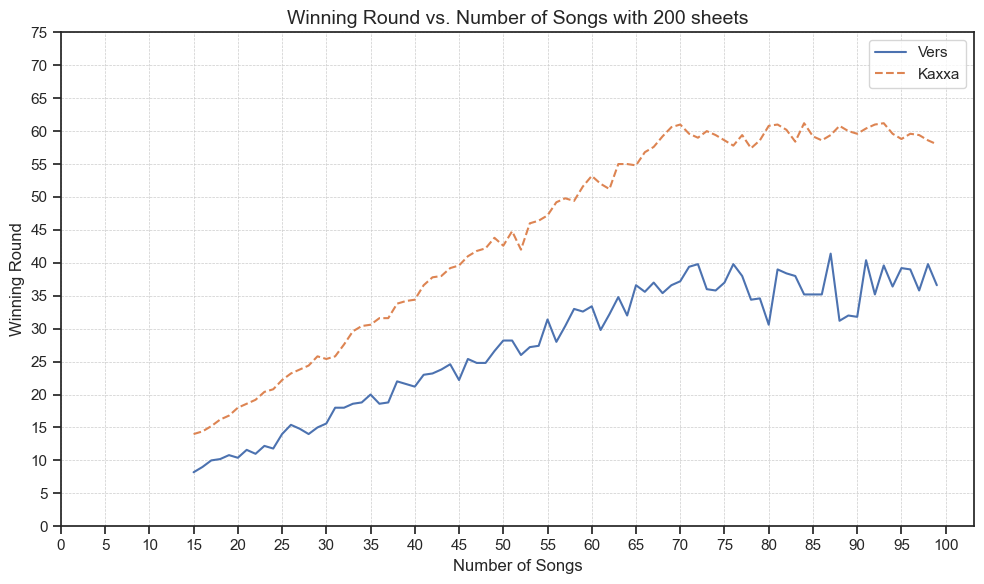

In [64]:
x = [p[0] for p in data]
y_vers = [p[1] for p in data]
y_kaxxa = [p[2] for p in data]

sns.set_theme(style="ticks")


fig, ax = plt.subplots(figsize=(10, 6))

#Plot each line
ax.plot(x, y_vers, label="Vers", linestyle='-')
ax.plot(x, y_kaxxa, label="Kaxxa",  linestyle='--')

ax.set_yticks(np.arange(0, 80, 5))
ax.set_xticks(np.arange(0, 105, 5))
ax.set_ylabel("Winning Round", fontsize=12)
ax.set_xlabel("Number of Songs", fontsize=12)
ax.set_title(f"Winning Round vs. Number of Songs with {NUM_GRIDS} sheets", fontsize=14)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.legend()

plt.tight_layout()
plt.show()